In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd 'drive'


/content/drive


In [4]:
%cd 'My Drive/techtable'

/content/drive/My Drive/techtable


In [5]:
from cifar100 import *

In [6]:
from torchvision import transforms
transform_test=transforms.Compose([
                 transforms.ToTensor(),   
])


In [7]:
train=CIFAR100(root='data',download=True,transform=transform_test)
test=CIFAR100(root='data',download=True,train=False,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print(train)

Dataset CIFAR100
    Number of datapoints: 50000
    Split: train
    Root Location: data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


In [9]:
img,label,index=train.__getitem__(65)

In [10]:
label

35

In [11]:
test.__len__()

10000

In [12]:
train.__repr__()

'Dataset CIFAR100\n    Number of datapoints: 50000\n    Split: train\n    Root Location: data\n    Transforms (if any): Compose(\n                             ToTensor()\n                         )\n    Target Transforms (if any): None'

35


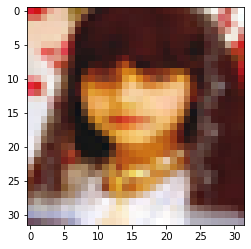

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img.permute(1,2,0))
print(label)

In [14]:
import torch
from torch.utils.data import random_split

In [15]:
random_seed=42
torch.manual_seed(random_seed)

In [16]:
#Splitting into Train and Validation Sets
val_size=5000
train_size=len(train)-val_size

train_ds,val_ds=random_split(train,[train_size,val_size])

In [17]:
len(train_ds),len(val_ds)

(45000, 5000)

In [18]:
#Loading the images in batches
from torch.utils.data.dataloader import DataLoader
batch_size=128

In [19]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

In [20]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels,_ in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

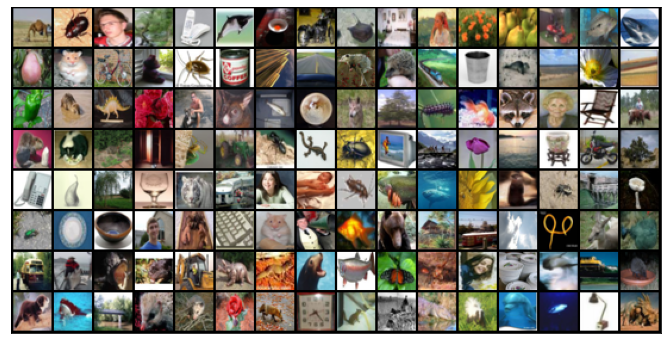

In [21]:
show_batch(train_dl)

In [22]:
#Building the model

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels,_ = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels,_ = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
  



In [33]:
class Cifar100CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
           nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0,1),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0,1),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0,1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0,1),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 100))
            
            
        
    def forward(self, xb):
      return self.network(xb)

In [34]:
model=Cifar100CnnModel()
model

Cifar100CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0, inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0, inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0, inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0, inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15)

In [35]:
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

In [36]:
device = get_default_device()
device

device(type='cuda')

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
model = to_device(Cifar100CnnModel(), device)

In [40]:
evaluate(model, val_dl)

{'val_acc': 0.0072265625931322575, 'val_loss': 4.605088233947754}

In [41]:
num_epochs = 6
opt_func = torch.optim.Adam
lr = 0.001

In [42]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 4.2038, val_loss: 3.7917, val_acc: 0.1048
Epoch [1], train_loss: 3.5626, val_loss: 3.3810, val_acc: 0.1811
Epoch [2], train_loss: 3.1348, val_loss: 3.0407, val_acc: 0.2461
Epoch [3], train_loss: 2.8289, val_loss: 2.8680, val_acc: 0.2947
Epoch [4], train_loss: 2.5622, val_loss: 2.7296, val_acc: 0.3085
Epoch [5], train_loss: 2.3051, val_loss: 2.6351, val_acc: 0.3412


In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

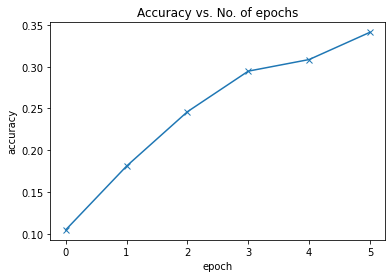

In [44]:
plot_accuracies(history)

In [45]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

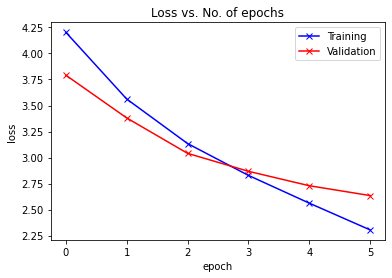

In [46]:
plot_losses(history)

In [47]:
test_dl=DataLoader(test,batch_size*2,num_workers=4,pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [48]:
evaluate(model,test_dl)

{'val_acc': 0.34648436307907104, 'val_loss': 2.640336751937866}

In [49]:
train_on_gpu=torch.cuda.is_available()

In [50]:
predicted_values=[]
model.eval()
for data,target,_ in test_dl:
  output=model(data)
  _,pred=torch.max(output,1)
  p=pred.cpu().numpy()
  t=p.tolist()
  predicted_values.append(t)
  

  

In [51]:
print(len(predicted_values))

40


In [52]:
flat_list = []
for sublist in predicted_values:
  for item in sublist:
    flat_list.append(item)

In [53]:
arr=np.arange(0,10000)

In [54]:
arr=pd.Series(arr)

In [55]:
arr1=arr.to_frame()

In [56]:
arr2=pd.DataFrame(flat_list)

In [57]:
df=pd.concat([arr1,arr2],ignore_index=True,axis=1)

In [58]:
df.to_csv("submission.csv",header=["Id","Category"],index=False)